## Новый код

In [136]:
import datetime
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.backends import cudnn
import torch.nn as nn
from torcheval.metrics.functional import multiclass_accuracy

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

import cv2
from keras.utils import to_categorical

import PIL.Image

from os.path import join as pjoin
import os

from tqdm import tqdm

In [213]:
import json

In [137]:
from utils import test_i_sample, test_x_sample
from my_dataset import MyDataset
from tf_callback import images_to_probs, plot_classes_preds, plot_confusion_matrix, plot_to_image
from metrics import runningScore

In [138]:
now = datetime.datetime.now()
model_name = f'model_{now.strftime("%d%m_%H%M")}'

In [139]:
print(model_name)

model_0207_2349


In [215]:
python_seed = 245
np_seed = 123
torch_seed = 321
torch_cuda_seed = 111
step = 50
split_test = 0.15
learning_rate = 0.001

In [216]:
params_dict = {
    'python_seed' : python_seed,
    'np_seed' : np_seed,
    'torch_seed' : torch_seed,
    'torch_cuda_seed' : torch_cuda_seed,
    'step' : step,
    'split_test' : split_test,
    'learning_rate' : learning_rate
}

In [218]:
with open(pjoin('models', model_name, 'params.json'), 'w') as f:
    json.dump(params_dict, f)

In [141]:
torch.use_deterministic_algorithms(True)

In [142]:
random.seed(python_seed)
np.random.seed(np_seed)
torch.manual_seed(torch_seed)
torch.cuda.manual_seed(torch_cuda_seed)


### Create train and val datasets

In [143]:
im_shape=(401,701)
iline, xline = im_shape
vert_locations = np.arange(0, iline, step)
horz_locations = np.arange(0, xline, step)

In [144]:
vert_mask = np.array(vert_locations) // step % round(1 / split_test) == 0
horz_mask = np.array(horz_locations) // step % round(1 / split_test) == 0
p_tr_list = ['i_' + str(ii) for ii in vert_locations[~vert_mask]] + ['x_' + str(ii) for ii in horz_locations[~horz_mask]]
p_vl_list = ['i_' + str(ii) for ii in vert_locations[vert_mask]] + ['x_' + str(ii) for ii in horz_locations[horz_mask]]

In [145]:
vert_mask

array([ True, False, False, False, False, False, False,  True, False])

In [146]:
random.shuffle(p_tr_list)
# random.shuffle(p_vl_list)

In [148]:
len(p_tr_list), len(p_vl_list)

(19, 5)

In [149]:
path_data = 'data'

In [150]:
path_splits = pjoin(path_data, 'splits')
    
if not os.path.exists(path_splits):
    os.makedirs(path_splits)

In [151]:
file_object = open(pjoin(path_splits, 'train.txt'), 'w')
file_object.write('\n'.join(p_tr_list))
file_object.close()

file_object = open(pjoin(path_splits, 'val.txt'), 'w')
file_object.write('\n'.join(p_vl_list))
file_object.close()

### Сохраняем пример снимка и меток

In [152]:
# seismic = np.load(pjoin(path_data,'train','train_seismic.npy'))
# labels  = np.load(pjoin(path_data,'train','train_labels.npy' ))
# np.save('seismic_example_i.npy', seismic[131])
# np.save('labels_example_i.npy', labels[131])
# np.save('seismic_example_i_1.npy', seismic[-43])
# np.save('labels_example_i_1.npy', labels[-43])

# np.save('seismic_example_x.npy', seismic[:,246])
# np.save('labels_example_x.npy', labels[:,246])
# np.save('seismic_example_x_1.npy', seismic[:,-23])
# np.save('labels_example_x_1.npy', labels[:,-23])

### Трансформация (кроп) torchvision transforms

In [153]:
rand_crop_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(padding=1, padding_mode='edge'),
    transforms.RandomCrop(256),
    transforms.RandomVerticalFlip(p=0.5)
])

#### Проверка трансформации

In [154]:
seismic_example_i = np.load('seismic_example_i.npy')
labels_example_i = np.load('labels_example_i.npy')
labels_cat_example_i = to_categorical(labels_example_i, num_classes=6)

seismic_example_i_1 = np.load('seismic_example_i_1.npy')
labels_example_i_1 = np.load('labels_example_i_1.npy')
labels_cat_example_i_1 = to_categorical(labels_example_i_1, num_classes=6)

In [155]:
seismic_example_x = np.load('seismic_example_x.npy')
labels_example_x = np.load('labels_example_x.npy')
labels_cat_example_x = to_categorical(labels_example_x, num_classes=6)

seismic_example_x_1 = np.load('seismic_example_x_1.npy')
labels_example_x_1 = np.load('labels_example_x_1.npy')
labels_cat_example_x_1 = to_categorical(labels_example_x_1, num_classes=6)

In [156]:
labels_cat_example_i.shape

(701, 255, 6)

In [157]:
np.expand_dims(seismic_example_i, axis=-1).shape

(701, 255, 1)

In [158]:
stacked = np.dstack([np.expand_dims(seismic_example_i, axis=-1), labels_cat_example_i])
stacked = rand_crop_1(stacked)
im, lbl = stacked[0], stacked[1:]
print(im.shape, lbl.shape)

torch.Size([256, 256]) torch.Size([6, 256, 256])


In [159]:
lbl[lbl % 1 != 0] #.round().int()

tensor([], dtype=torch.float64)

In [160]:
np.argmax(lbl, axis=0)

tensor([[0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        [0, 0, 0,  ..., 4, 4, 4],
        ...,
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5]])

In [161]:
seismic_arr_i = np.array([seismic_example_i, seismic_example_i_1])
labels_cat_arr_i = np.array([labels_cat_example_i, labels_cat_example_i_1])

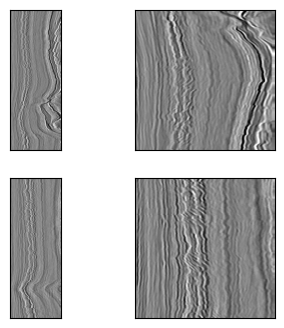

In [162]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4, 4))
for i, image in enumerate(seismic_arr_i):
    axs[i][0].imshow(image, cmap='gray')
    axs[i][1].imshow(rand_crop_1(image).permute(1,2,0), cmap='gray')
for i in range(2):
    for j in range(2):
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

In [163]:
# нарисовать через opencv привязать метки к классам

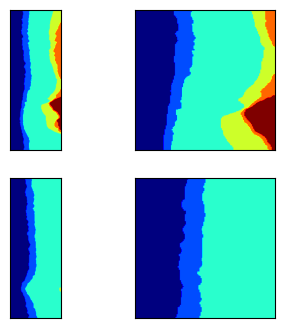

In [164]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4, 4))
for i, image in enumerate(labels_cat_arr_i):
    axs[i][0].imshow(np.argmax(image,axis =-1), cmap='jet', vmin=0, vmax=5)
    axs[i][1].imshow(np.argmax(rand_crop_1(image).permute(1,2,0), axis=-1), cmap='jet', vmin=0, vmax=5)

for i in range(2):
    for j in range(2):
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

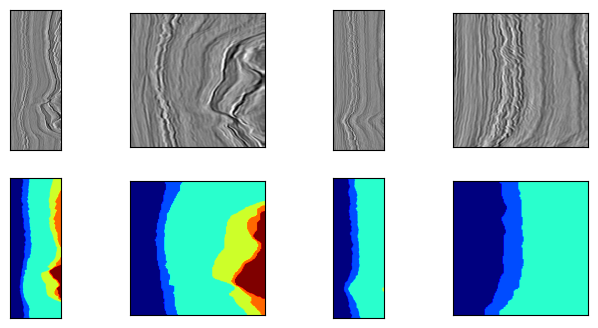

In [165]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
for i, image in enumerate(seismic_arr_i):
    stacked = np.dstack([np.expand_dims(image, axis=-1), labels_cat_arr_i[i]])
    stacked = rand_crop_1(stacked)
    im, lbl = stacked[0], stacked[1:]
    axs[0][2*i].imshow(image, cmap='gray')
    axs[0][2*i+1].imshow(im, cmap='gray')
    axs[1][2*i].imshow(np.argmax(labels_cat_arr_i[i], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[1][2*i+1].imshow(np.argmax(lbl.permute(1,2,0), axis=-1), cmap='jet', vmin=0, vmax=5)
    for j in range(2):
        axs[j][2*i].xaxis.set_major_locator(ticker.NullLocator())
        axs[j][2*i].yaxis.set_major_locator(ticker.NullLocator())
        axs[j][2*i+1].xaxis.set_major_locator(ticker.NullLocator())
        axs[j][2*i+1].yaxis.set_major_locator(ticker.NullLocator())
plt.show()

### Делаем загрузчик данных

In [166]:
train_dataset = MyDataset(split='train', transform=rand_crop_1)
val_dataset = MyDataset(split='val', transform=rand_crop_1)

In [167]:
len(train_dataset), len(val_dataset)

(19, 5)

In [192]:
batch_size = 8
num_epochs = 150
num_classes = 6

In [169]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### Проверка DataLoader-ов

In [170]:
image_tensor, label_tensor = next(iter(train_loader))
len(train_loader)

3

In [171]:
image_tensor.shape, label_tensor.shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 6, 256, 256]))

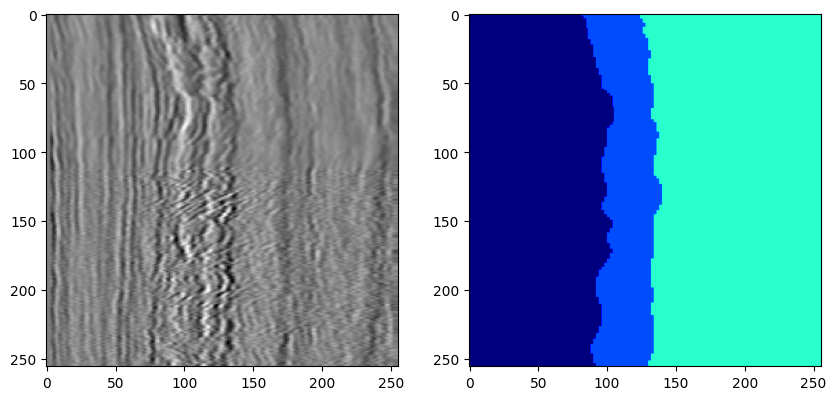

In [172]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axs[0].imshow(image_tensor[0,0,:,:], cmap='gray')
axs[1].imshow(np.argmax(label_tensor[0,:,:,:],axis=0), cmap='jet', vmin=0, vmax=5)
plt.show()

In [173]:
image_tensor.max(), image_tensor.min() # нормировка должна быть внутри класса

(tensor(1.), tensor(-1.))

### Моделька

In [174]:
# Создаем U-Net модель с энкодером resnet34
model = smp.Unet(
    encoder_name="resnet18", # resnet18 
    # encoder_weights="swsl", # можно обучать с нуля
    in_channels=1,
    classes=6,  # Количество классов для сегментации
)

### Loss, merics, optimizer

In [175]:
log_dict = {
    'ca': np.zeros((num_classes, num_epochs)),
    'mca': np.zeros((num_epochs)),
    'iou': np.zeros((num_classes, num_epochs)),
    'mciou': np.zeros((num_epochs)),
    'fwiou': np.zeros((num_epochs)),
    'smp_iou': np.zeros((num_epochs)),
    'smp_loss': np.zeros((num_epochs)),
    'sk_loss': np.zeros((num_epochs))
}

In [176]:
# # Определяем функцию потерь и оптимизатор
loss = [smp.utils.losses.DiceLoss(), nn.CrossEntropyLoss()] # указать количество классов?
metrics = [smp.utils.metrics.IoU(threshold=0.5)] # threshold ?? 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss = [smp.losses.DiceLoss('multiclass'), smp.losses.SoftCrossEntropyLoss()]
# metrics = smp.metrics.iou_score

In [177]:
# Определяем устройство для обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [178]:
# Переносим модель и функцию потерь на устройство
model = model.to(device)
loss[0] = loss[0].to(device)
loss[1] = loss[1].to(device)

### Learning

#### Tensorboard settings

In [193]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(pjoin('models', model_name, 'runs'))

In [194]:
# helper functions



#### Training

In [195]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [196]:
len(train_loader), len(val_loader)

(3, 1)

In [197]:
if not os.path.exists(pjoin('models', model_name, 'disasters')):
    os.makedirs(pjoin('models', model_name, 'disasters'))

In [198]:
best_metric_arr = -np.ones(4)
best_model_arr = [model for i in range(4)]

In [199]:
best_metric_0 = -1
best_model_0 = model

In [200]:
running_loss = [0.0, 0.0]

In [201]:
metric_names = ['Pixel Acc', 'Mean Class Acc', 'Freq Weighted IoU', 'Mean IoU']

In [202]:
running_metrics = runningScore(num_classes)
running_metrics_val = runningScore(num_classes)

In [203]:
smp_loss_logs = np.zeros((num_epochs, len(loss)))
smp_iu_logs = np.zeros(num_epochs)

In [204]:
pa_logs = np.zeros(num_epochs)
ca_logs = np.zeros((num_epochs, num_classes))
mca_logs = np.zeros(num_epochs)
iu_logs = np.zeros((num_epochs, num_classes))
mciu_logs = np.zeros(num_epochs)
fwiu_logs = np.zeros(num_epochs)
cm_logs = np.zeros((num_epochs, num_classes, num_classes))

In [205]:
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    # Обучение
    model.train()

    running_loss = [0.0, 0.0]
    number_of_batches = len(train_loader)

    last_batch = (0,0)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # images.shape = torch.Size([batch_size, 1, 256, 256])
        # labels.shape = torch.Size([batch_size, 6, 256, 256])

        optimizer.zero_grad()

        outputs = model(images)
        # outputs.shape = torch.Size([batch_size, 6, 256, 256])
        outputs = nn.Softmax(dim=1)(outputs)
        # outputs_lbl.shape = torch.Size([batch_size, 6, 256, 256])

        outputs_lbl = np.argmax(outputs.detach().numpy(), axis=1)
        labels_trues = np.argmax(labels.reshape(outputs.shape), axis=1)

        for i, l in enumerate(loss):
            running_loss[i] += l(outputs, labels.reshape(outputs.shape)).item()

        running_metrics.update(labels_trues, outputs_lbl)

        loss_value = loss[0](outputs, labels.reshape(outputs.shape)) + loss[1](outputs, labels.reshape(outputs.shape))
        loss_value.backward()
        optimizer.step()
    
        last_batch = (images, labels)

        if loss_value.item() < 0:
            np.save(pjoin('models', model_name, 'disasters',
                          f'nl_output_{epoch}_{i}.npy'),
                          outputs.detach().numpy())

    # log loss[0]
    writer.add_scalar('train/DiceLoss',
                      running_loss[0] / number_of_batches,
                      epoch+1)
    smp_loss_logs[0] = running_loss[0] / number_of_batches

    # log loss[1]
    writer.add_scalar('train/CrossEntropyLoss',
                      running_loss[1] / number_of_batches,
                      epoch+1)
    smp_loss_logs[1] = running_loss[1] / number_of_batches
    
    # log the running loss
    writer.add_scalar('train/loss(sum)',
                      sum(running_loss) / number_of_batches,
                      epoch+1)

    # log a Matplotlib Figure showing the model's predictions on a
    # last mini-batch
    # print(last_batch)
    # print(last_batch[0].shape, last_batch[1].shape)
    writer.add_figure(f'train/true vs pred',
                      plot_classes_preds(model, last_batch[0], last_batch[1], epoch),
                      global_step = epoch+1)

    score, class_iu = running_metrics.get_scores()

    for m in metric_names:
        writer.add_scalar(f'train/{m}',
                          score[f'{m}: '], epoch+1)

    # pa_logs[epoch] = score['Pixel Acc: ']
    # mca_logs[epoch] = score['Mean Class Acc: ']
    # fwiu_logs[epoch] = score['Freq Weighted IoU: ']
    # mciu_logs[epoch] = score['Mean IoU: ']

    for i, _ca in enumerate(score['Class Accuracy: ']):
        writer.add_scalar(f'train/Class[{i}] Accuracy',
                          _ca, epoch+1)
        # ca_logs[epoch][i] = _ca

        writer.add_scalar(f'train/Class[{i}] IoU',
                          class_iu[i], epoch+1)
        # iu_logs[epoch][i] = class_iu[i]

    cm = score['confusion_matrix']

    writer.add_figure(f'train/Confusion Matrix',
                      plot_confusion_matrix(cm, list(range(num_classes))),
                      global_step = epoch+1)
    # cm_logs[epoch] = cm

    running_metrics.reset()


    # Валидация
    model.eval()
    total_metric_0 = 0
    num_samples = 0
    number_of_batches = len(val_loader)

    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        number_of_batches = len(val_loader)
        
        with torch.no_grad():
            outputs = model(images)
            # outputs.shape = torch.Size([batch_size, 6, 256, 256])
            outputs = nn.Softmax(dim=1)(outputs)
            # outputs.shape = torch.Size([batch_size, 6, 256, 256])
            
            outputs_lbl = np.argmax(outputs.detach().numpy(), axis=1)
            labels_trues = np.argmax(labels.reshape(outputs.shape), axis=1)

            metric_value_0 = metrics[0](outputs, labels.reshape(outputs.shape))
            total_metric_0 += metric_value_0.item() * images.size(0)

            running_metrics_val.update(labels_trues, outputs_lbl)
            

            num_samples += images.size(0)
            
            last_batch = (images, labels)

    writer.add_figure(f'val/true vs pred',
        plot_classes_preds(model, last_batch[0], last_batch[1], epoch),
        global_step=epoch)
        
    average_metric_0 = total_metric_0 / num_samples

    writer.add_scalar('val/smp_metrics',
                      average_metric_0,
                      epoch+1)

    score, class_iu = running_metrics_val.get_scores()

    for m in metric_names:
        writer.add_scalar(f'val/{m}',
                          score[f'{m}: '], epoch+1)

    pa_logs[epoch] = score['Pixel Acc: ']
    mca_logs[epoch] = score['Mean Class Acc: ']
    fwiu_logs[epoch] = score['Freq Weighted IoU: ']
    mciu_logs[epoch] = score['Mean IoU: ']

    for i, _ca in enumerate(score['Class Accuracy: ']):
        writer.add_scalar(f'val/Class[{i}] Accuracy',
                          _ca, epoch+1)
        ca_logs[epoch][i] = _ca

        writer.add_scalar(f'val/Class[{i}] IoU',
                          class_iu[i], epoch+1)
        iu_logs[epoch][i] = class_iu[i]

    cm = score['confusion_matrix']

    writer.add_figure(f'val/Confusion Matrix',
                      plot_confusion_matrix(cm, list(range(num_classes))),
                      global_step = epoch+1)
    cm_logs[epoch] = cm

    running_metrics_val.reset()
    
    # Вывод прогресса обучения
    # print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_value.item():.4f}, Metric: {average_metric:.4f}')

    # сохранение чекпойнта (если метрика стала лучше)
    if best_metric_0 < average_metric_0:
        best_metric_0 = average_metric_0
        best_model_0 = model
    
    for i, m in enumerate(metric_names):
        if best_metric_arr[i] < score[f'{m}: ']:
            best_metric_arr[i] = score[f'{m}: ']
            best_model_arr[i] = model


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

Epochs:   1%|          | 1/150 [00:15<38:29, 15.50s/it]z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\tf_callback.py:72: RuntimeWarning: invalid value encountered in divide
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
Epochs:   1%|▏         | 2/150 [00:29<36:14, 14.69s/it]z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\tf_callback.py:72: RuntimeWarning: invalid value encountered in divide
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
Epochs:   3%|▎         | 4/150 [01:00<36:13, 14.89s/it]z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\tf_callback.py:72: RuntimeWarning: inval

In [206]:
print(number_of_batches)

1


In [207]:
print(f'best_metric_0 = {best_metric_0}')

best_metric_0 = 0.9758407473564148


In [208]:
for i, m in enumerate(metric_names):
    print(f'best_metric[{m}] = {best_metric_arr[i]}')

best_metric[Pixel Acc] = 0.9877685546875
best_metric[Mean Class Acc] = 0.9812386619998181
best_metric[Freq Weighted IoU] = 0.9760575315169078
best_metric[Mean IoU] = 0.9597221236729896


In [209]:
torch.save(best_model_0.state_dict(), pjoin('models', model_name, f'best_0_{model_name}.pth'))
for i, m in enumerate(metric_names):
    torch.save(best_model_arr[i].state_dict(), pjoin('models', model_name, f'best_{m}_{model_name}.pth'))

In [211]:
if not os.path.exists(pjoin('models', model_name, 'logs')):
    os.makedirs(pjoin('models', model_name, 'logs'))

In [212]:
np.save(pjoin('models', model_name, 'logs', 'smp_loss_logs.npy'),   smp_loss_logs)
np.save(pjoin('models', model_name, 'logs', 'smp_iu_logs.npy'), smp_iu_logs)
np.save(pjoin('models', model_name, 'logs', 'pa_logs.npy'), pa_logs)
np.save(pjoin('models', model_name, 'logs', 'ca_logs.npy'), ca_logs)
np.save(pjoin('models', model_name, 'logs', 'mca_logs .npy'),   mca_logs )
np.save(pjoin('models', model_name, 'logs', 'iu_logs.npy'), iu_logs)
np.save(pjoin('models', model_name, 'logs', 'mciu_logs.npy'), mciu_logs)
np.save(pjoin('models', model_name, 'logs', 'fwiu_logs.npy'),   fwiu_logs)
np.save(pjoin('models', model_name, 'logs', 'cm_logs.npy'), cm_logs)

In [219]:
# model.load_state_dict(torch.load(pjoin('models', model_name, f'{model_name}.pth')))
# model = last_model

In [220]:
best_model = best_model_0

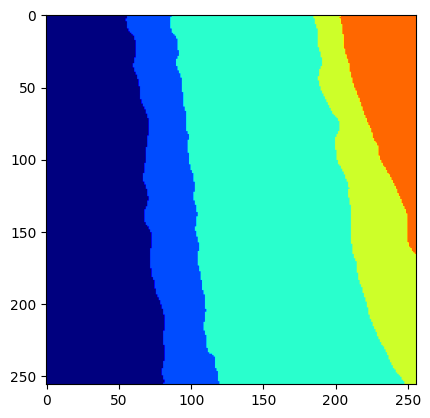

In [221]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
image_tensor, label_tensor = next(iter(train_loader))
output = nn.Softmax(dim=1)(best_model(image_tensor))
output = output.detach().numpy()
plt.imshow(np.argmax(output,axis=1)[0], cmap='jet', vmin=0, vmax=5)
plt.show()

### Тестируем на полном срезе

In [222]:
seismic_example_i_1.shape, labels_cat_example_i_1.shape

((701, 255), (701, 255, 6))

In [223]:
seismic_example_x_1.shape, labels_cat_example_x_1.shape

((401, 255), (401, 255, 6))

In [224]:
running_metrics_test = runningScore(num_classes)

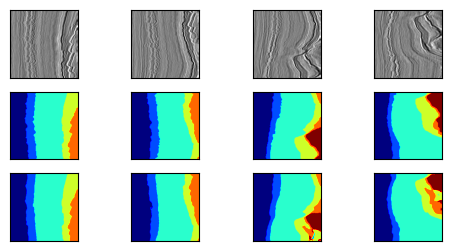

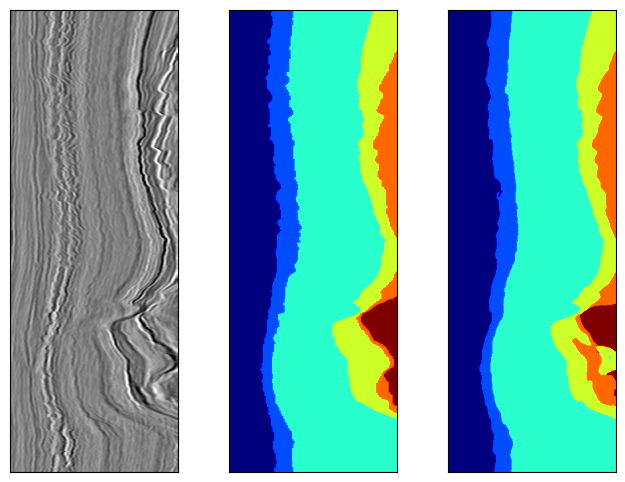

Pixel Acc: 	0.9687561187099661
Mean Class Acc: 	0.9130337773393494
Freq Weighted IoU: 	0.9426406808576636
Mean IoU: 	0.8612093699856649
Class[0] Accuracy:	0.9960896240195968
Class[0] IoU:     	0.9822153611909998
Class[1] Accuracy:	0.9304413673734314
Class[1] IoU:     	0.9130363691574596
Class[2] Accuracy:	0.994305972051914
Class[2] IoU:     	0.9860070801979683
Class[3] Accuracy:	0.9101805124223602
Class[3] IoU:     	0.8923022908803652
Class[4] Accuracy:	0.918918918918919
Class[4] IoU:     	0.9207818930041153
Class[5] Accuracy:	0.7282662692498758
Class[5] IoU:     	nan


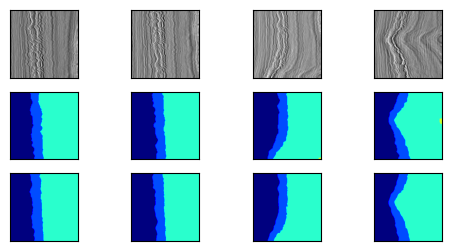

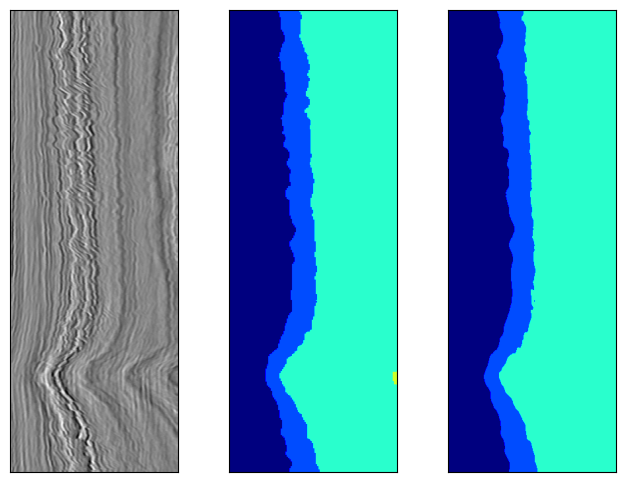

Pixel Acc: 	0.987082878800593
Mean Class Acc: 	0.7354405857197008
Freq Weighted IoU: 	0.9747767763808335
Mean IoU: 	0.7214150434138753
Class[0] Accuracy:	0.994142632047681
Class[0] IoU:     	0.9822153611909998
Class[1] Accuracy:	0.9552177653951736
Class[1] IoU:     	0.9130363691574596
Class[2] Accuracy:	0.9924019454359488
Class[2] IoU:     	0.9860070801979683
Class[3] Accuracy:	0.0
Class[3] IoU:     	0.8923022908803652
Class[4] Accuracy:	nan
Class[4] IoU:     	0.9207818930041153
Class[5] Accuracy:	nan
Class[5] IoU:     	nan


z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\metrics.py:36: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


In [225]:
_, true_lbls, outputs = test_i_sample(best_model, seismic_example_i, labels_cat_example_i, show_plots=True)
running_metrics_test.update(np.argmax(true_lbls, axis=-1), np.argmax(outputs, axis=-1))
score, iu = running_metrics_test.get_scores()
running_metrics_test.reset()

for i, m in enumerate(metric_names):
    _s = score[f'{m}: ']
    print(f'{m}: \t{_s}')

for i, _ca in enumerate(score['Class Accuracy: ']):
    print(f'Class[{i}] Accuracy:\t{_ca}')
    print(f'Class[{i}] IoU:     \t{class_iu[i]}')


_, true_lbls, outputs = test_i_sample(best_model, seismic_example_i_1, labels_cat_example_i_1, show_plots=True)
running_metrics_test.update(np.argmax(true_lbls, axis=-1), np.argmax(outputs, axis=-1))
score, iu = running_metrics_test.get_scores()
running_metrics_test.reset()

for i, m in enumerate(metric_names):
    _s = score[f'{m}: ']
    print(f'{m}: \t{_s}')

for i, _ca in enumerate(score['Class Accuracy: ']):
    print(f'Class[{i}] Accuracy:\t{_ca}')
    print(f'Class[{i}] IoU:     \t{class_iu[i]}')



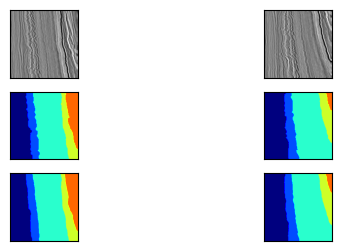

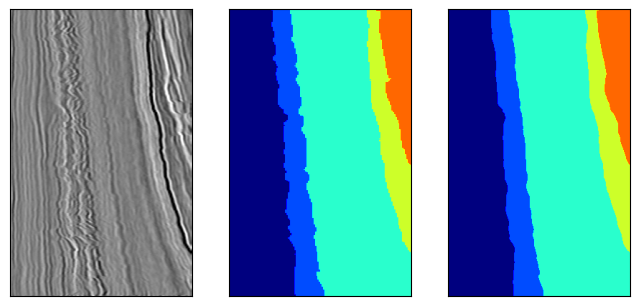

z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\metrics.py:36: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


Pixel Acc: 	0.987638746271576
Mean Class Acc: 	0.9836309970961032
Freq Weighted IoU: 	0.9757830783762798
Mean IoU: 	0.9654564552913077
Class[0] Accuracy:	0.9947986086278079
Class[0] IoU:     	0.9822153611909998
Class[1] Accuracy:	0.9674590163934427
Class[1] IoU:     	0.9130363691574596
Class[2] Accuracy:	0.9900704748609641
Class[2] IoU:     	0.9860070801979683
Class[3] Accuracy:	0.975443715049842
Class[3] IoU:     	0.8923022908803652
Class[4] Accuracy:	0.9903831705484598
Class[4] IoU:     	0.9207818930041153
Class[5] Accuracy:	nan
Class[5] IoU:     	nan


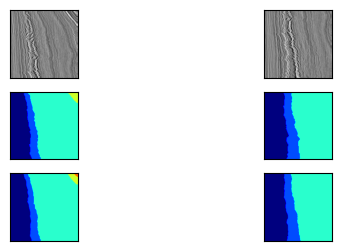

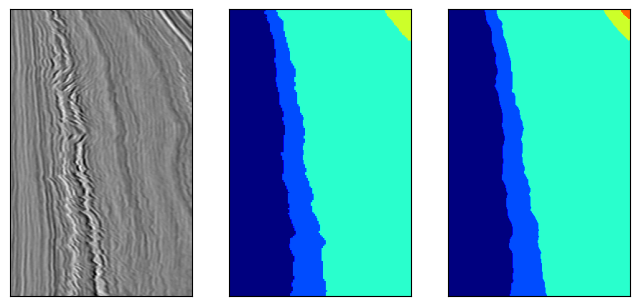

Pixel Acc: 	0.9880103662412596
Mean Class Acc: 	0.942049628700329
Freq Weighted IoU: 	0.9777536481927841
Mean IoU: 	0.7446505397372861
Class[0] Accuracy:	0.9953090416570315
Class[0] IoU:     	0.9822153611909998
Class[1] Accuracy:	0.9360329111881907
Class[1] IoU:     	0.9130363691574596
Class[2] Accuracy:	0.9978652913450372
Class[2] IoU:     	0.9860070801979683
Class[3] Accuracy:	0.8389912706110573
Class[3] IoU:     	0.8923022908803652
Class[4] Accuracy:	nan
Class[4] IoU:     	0.9207818930041153
Class[5] Accuracy:	nan
Class[5] IoU:     	nan


z:\Practice6\ravil_project\metrics.py:34: RuntimeWarning: invalid value encountered in divide
  ca = np.diag(hist) / hist.sum(axis=1)
z:\Practice6\ravil_project\metrics.py:36: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


In [226]:
_, true_lbls, outputs = test_x_sample(best_model, seismic_example_x, labels_cat_example_x, show_plots=True)
running_metrics_test.update(np.argmax(true_lbls, axis=-1), np.argmax(outputs, axis=-1))
score, iu = running_metrics_test.get_scores()
running_metrics_test.reset()

for i, m in enumerate(metric_names):
    _s = score[f'{m}: ']
    print(f'{m}: \t{_s}')

for i, _ca in enumerate(score['Class Accuracy: ']):
    print(f'Class[{i}] Accuracy:\t{_ca}')
    print(f'Class[{i}] IoU:     \t{class_iu[i]}')


_, true_lbls, outputs = test_x_sample(best_model, seismic_example_x_1, labels_cat_example_x_1, show_plots=True)
running_metrics_test.update(np.argmax(true_lbls, axis=-1), np.argmax(outputs, axis=-1))
score, iu = running_metrics_test.get_scores()
running_metrics_test.reset()

for i, m in enumerate(metric_names):
    _s = score[f'{m}: ']
    print(f'{m}: \t{_s}')

for i, _ca in enumerate(score['Class Accuracy: ']):
    print(f'Class[{i}] Accuracy:\t{_ca}')
    print(f'Class[{i}] IoU:     \t{class_iu[i]}')

### Тестируем на всех срезах i и x

In [227]:
seismic = np.load(pjoin(path_data,'train','train_seismic.npy'))
labels  = np.load(pjoin(path_data,'train','train_labels.npy' ))

In [228]:
data_shape = seismic.shape

In [229]:
pred_labels_cat_i = np.zeros((data_shape[0], data_shape[1], data_shape[2], 6))

In [230]:
for i in tqdm(range(data_shape[0])):
    im = seismic[i]
    lbl = to_categorical(labels[i], num_classes=6)
    _, lbl_cat, pred_lbl_cat = test_i_sample(best_model, im, lbl, False)
    pred_labels_cat_i[i] = pred_lbl_cat

 42%|████▏     | 170/401 [02:51<03:40,  1.05it/s]

In [ ]:
pred_labels_cat_x = np.zeros((data_shape[0], data_shape[1], data_shape[2], 6))

In [ ]:
for i in tqdm(range(data_shape[1])):
    im = seismic[:,i]
    lbl = to_categorical(labels[:,i], num_classes=6)
    _, lbl_cat, pred_lbl_cat = test_x_sample(best_model, im, lbl, False)
    pred_labels_cat_x[:,i,:,:] = pred_lbl_cat

100%|██████████| 701/701 [05:28<00:00,  2.13it/s]


In [ ]:
np.save(pjoin('models', model_name, 'pred_labels_cat_i.npy'), pred_labels_cat_i)
np.save(pjoin('models', model_name, 'pred_labels_cat_x.npy'), pred_labels_cat_x)

In [ ]:
pred_labels_cat_i = np.load(pjoin('models', model_name, 'pred_labels_cat_i.npy'))
pred_labels_cat_x  = np.load(pjoin('models', model_name, 'pred_labels_cat_x.npy'))

In [ ]:
print(model_name)

model_0207_2110


In [ ]:
torch.from_numpy(np.expand_dims(np.moveaxis(labels[3], -1, 0), axis=0)).shape

torch.Size([1, 255, 701])

In [ ]:
torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_i[3], -1, 0), axis=0)).shape

torch.Size([1, 6, 701, 255])

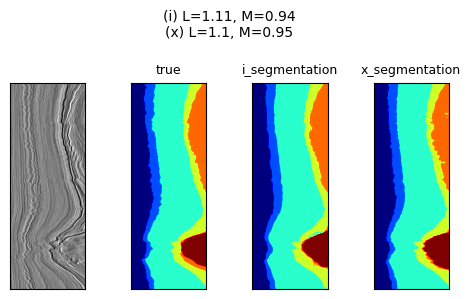

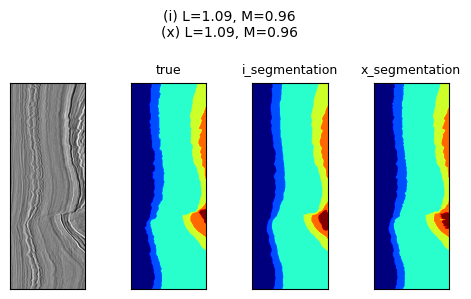

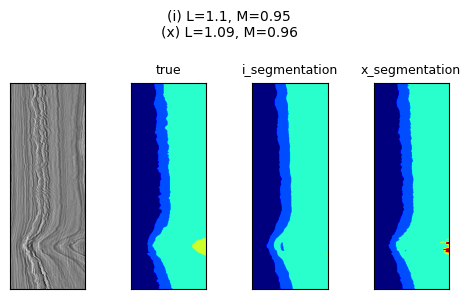

In [ ]:
i_slices = [33, 156, 366]

for i, idx in enumerate(i_slices):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(5, 3))
    axs[0].imshow(seismic[idx], cmap='gray')
    axs[1].imshow(labels[idx], cmap='jet', vmin=0, vmax=5)
    axs[1].set_title('true', fontsize=9)

    axs[2].imshow(np.argmax(pred_labels_cat_i[idx], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[2].set_title('i_segmentation', fontsize=9)

    axs[3].imshow(np.argmax(pred_labels_cat_x[idx], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[3].set_title('x_segmentation', fontsize=9)
    for j in range(4):
        axs[j].xaxis.set_major_locator(ticker.NullLocator())
        axs[j].yaxis.set_major_locator(ticker.NullLocator())

    lbl = torch.from_numpy(np.expand_dims(np.moveaxis(to_categorical(labels[idx],num_classes=6), -1, 0), axis=0))
    pred_i = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_i[idx], -1, 0), axis=0))
    pred_x = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_x[idx], -1, 0), axis=0))

    li = torch.round(loss[0](pred_i, lbl) + loss[1](pred_i, lbl), decimals=2)
    mi = torch.round(metrics[0](pred_i, lbl), decimals=2)
    lx = torch.round(loss[0](pred_x, lbl) + loss[1](pred_x, lbl), decimals=2)
    mx = torch.round(metrics[0](pred_x, lbl), decimals=2)
    fig.suptitle(f'(i) L={li}, M={mi}\n(x) L={lx}, M={mx}', fontsize=10)
    plt.tight_layout()
    plt.show()

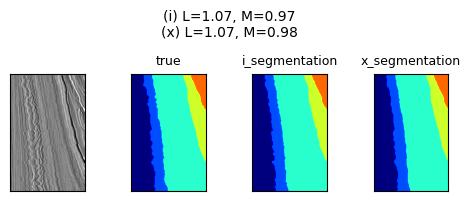

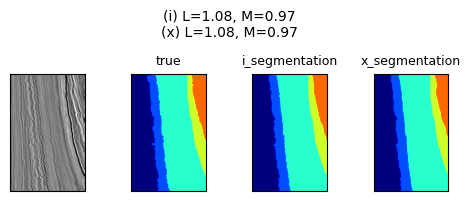

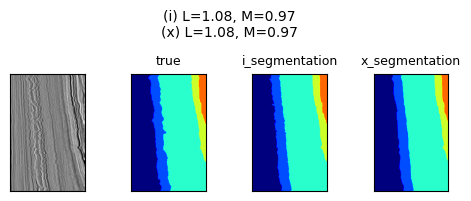

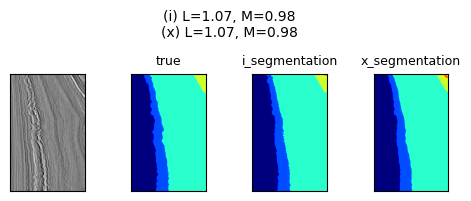

In [ ]:
x_slices = [56, 236, 311, 666]
for i, idx in enumerate(x_slices):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(5, 2))
    axs[0].imshow(seismic[:,idx], cmap='gray')
    axs[1].imshow(labels[:,idx], cmap='jet', vmin=0, vmax=5)
    axs[1].set_title('true', fontsize=9)

    axs[2].imshow(np.argmax(pred_labels_cat_i[:,idx], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[2].set_title('i_segmentation', fontsize=9)

    axs[3].imshow(np.argmax(pred_labels_cat_x[:,idx], axis=-1), cmap='jet', vmin=0, vmax=5)
    axs[3].set_title('x_segmentation', fontsize=9)
    for j in range(4):
        axs[j].xaxis.set_major_locator(ticker.NullLocator())
        axs[j].yaxis.set_major_locator(ticker.NullLocator())

    lbl = torch.from_numpy(np.expand_dims(np.moveaxis(to_categorical(labels[:,idx],num_classes=6), -1, 0), axis=0))
    pred_i = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_i[:,idx], -1, 0), axis=0))
    pred_x = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_x[:,idx], -1, 0), axis=0))

    li = torch.round(loss[0](pred_i, lbl) + loss[1](pred_i, lbl), decimals=2)
    mi = torch.round(metrics[0](pred_i, lbl), decimals=2)
    lx = torch.round(loss[0](pred_x, lbl) + loss[1](pred_x, lbl), decimals=2)
    mx = torch.round(metrics[0](pred_x, lbl), decimals=2)
    fig.suptitle(f'(i) L={li}, M={mi}\n(x) L={lx}, M={mx}', fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
for i in tqdm(range(data_shape[0])):
    lbl = torch.from_numpy(np.expand_dims(np.moveaxis(to_categorical(labels[i],num_classes=6), -1, 0), axis=0))
    pred_i = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_i[i], -1, 0), axis=0))
    pred_x = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_x[i], -1, 0), axis=0))

    li = torch.round(loss[0](pred_i, lbl) + loss[1](pred_i, lbl), decimals=2)
    mi = torch.round(metrics[0](pred_i, lbl), decimals=2)
    lx = torch.round(loss[0](pred_x, lbl) + loss[1](pred_x, lbl), decimals=2)
    mx = torch.round(metrics[0](pred_x, lbl), decimals=2)

    writer.add_scalar('test/(i_algo) loss along i', li, i)
    writer.add_scalar('test/(i_algo) metric along i', mi, i)
    writer.add_scalar('test/(x_algo) loss along i', lx, i)
    writer.add_scalar('test/(x_algo) metric along i', mx, i)
    

100%|██████████| 401/401 [00:50<00:00,  7.99it/s]


In [ ]:
for i in tqdm(range(data_shape[1])):
    lbl = torch.from_numpy(np.expand_dims(np.moveaxis(to_categorical(labels[:,i],num_classes=6), -1, 0), axis=0))
    pred_i = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_i[:,i], -1, 0), axis=0))
    pred_x = torch.from_numpy(np.expand_dims(np.moveaxis(pred_labels_cat_x[:,i], -1, 0), axis=0))

    li = torch.round(loss[0](pred_i, lbl) + loss[1](pred_i, lbl), decimals=2)
    mi = torch.round(metrics[0](pred_i, lbl), decimals=2)
    lx = torch.round(loss[0](pred_x, lbl) + loss[1](pred_x, lbl), decimals=2)
    mx = torch.round(metrics[0](pred_x, lbl), decimals=2)

    writer.add_scalar('test/(i_algo) loss along x', li, i)
    writer.add_scalar('test/(i_algo) metric along x', mi, i)
    writer.add_scalar('test/(x_algo) loss along x', lx, i)
    writer.add_scalar('test/(x_algo) metric along x', mx, i)
    

100%|██████████| 701/701 [00:55<00:00, 12.57it/s]


#### full metric

In [ ]:
lbl_i = torch.from_numpy(np.moveaxis(to_categorical(labels,num_classes=6), -1, 1))
pred_i = torch.from_numpy(np.moveaxis(pred_labels_cat_i, -1, 1))
lbl_x = torch.from_numpy(np.moveaxis(to_categorical(labels,num_classes=6), (1, -1), (0, 1)))
pred_x = torch.from_numpy(np.moveaxis(pred_labels_cat_x, (1, -1), (0, 1)))

li = torch.round(loss[0](pred_i, lbl_i) + loss[1](pred_i, lbl_i), decimals=2)
mi = torch.round(metrics[0](pred_i, lbl_i), decimals=2)
lx = torch.round(loss[0](pred_x, lbl_x) + loss[1](pred_x, lbl_x), decimals=2)
mx = torch.round(metrics[0](pred_x, lbl_x), decimals=2)

print(f'i_algo: loss={li}, metric={mi}')
print(f'x_algo: loss={lx}, metric={mx}')

i_algo: loss=1.09, metric=0.96
x_algo: loss=1.09, metric=0.96


In [ ]:
len(p_tr_list), len(p_vl_list)

(32, 6)

In [ ]:
i_list = []
x_list = []

In [ ]:
for p_list in [p_tr_list, p_vl_list]:
    for el in p_list:
        dir, idx = el.split('_')
        idx = int(idx)
        if dir == 'i':
            i_list.append(idx)
        else:
            x_list.append(idx)

In [ ]:
i_list = sorted(i_list)

In [ ]:
x_list = sorted(x_list)

In [ ]:
i_list in list(range(data_shape[0]))

False

In [ ]:
testmask_i = [i not in i_list for i in range(data_shape[0])]

In [ ]:
testmask_x = [x not in x_list for x in range(data_shape[1])]

In [ ]:
test_seismic_i = seismic[testmask_i]
test_labels_i = labels[testmask_i]

In [ ]:
test_seismic_x = seismic[:,testmask_x]
test_labels_x = labels[:,testmask_x]

In [ ]:
test_seismic_ix = seismic[testmask_i][:,testmask_x]
test_labels_ix = labels[testmask_i][:,testmask_x]

In [ ]:
test_seismic_ix.shape, test_labels_ix.shape

((387, 677, 255), (387, 677, 255))

### Задачи


<!--
V фиксировать сиды для рандомов (numpy, torch)

V Добавить прямо в трансформ аугментацию с корректными параметрами
V    переделать рандом кроп 255 -> 256
V    добавить паддинг в рандом кроп, вместо ресайз(256х256) (проверить как работает паддинг)

V shuffle = True для DataLoader-ов

V наладить отображение графиков (cmap='jet', vmin=0, vmax=5)

правильно ли вычисляются метрики и лосс
    можно реализовать самому

V построить график изменения метрики, лосса

V softmax на выходе

V сохранять каждый первый батч в эпохах - проверить, что они отличаются (проверил и убрал)

проверить баланс классов 
    веса "классов"
    посчитать взвешенную функцию потерь, в зависимости от распределения по классам

построить распред IoU для всех 6 классов, чтобы посмотреть на каком из классов больше ошибок

почему плохо обучается?
    learning rate?
-->

<!-- взять все метрики и лоссы из facies_classification_benchmark-master

при это понять в каком формате принимаются данные (shape) -->
